In [1]:
%matplotlib inline
import math
import torch
from torch import nn
from torch.nn import functional as F
from torch.autograd import Variable
from torch.distributions import Normal
from scipy.linalg import block_diag
from numpy.linalg import inv
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy.spatial.distance import pdist, squareform
import numpy.matlib as nm
import os
os.environ["KMP_DUPLICATE_LIB_OK"]  =  "TRUE"

In [2]:
def get_lstm_params(num_inputs, num_hiddens, num_outputs, num_units):
    
    def normal(shape):
        return Variable(nn.Parameter(torch.randn(size = shape))) * 0.01
    def zero(shape):
        return Variable(nn.Parameter(torch.zeros(shape)))
    def three(num_inputs, num_hiddens, num_outputs):
        return (normal((num_inputs, num_hiddens)), normal((num_hiddens, num_hiddens)), zero(num_hiddens))
    
    W_xi, W_hi, b_i = three(num_inputs, num_hiddens, num_outputs) # 输入门参数
    W_xf, W_hf, b_f = three(num_inputs, num_hiddens, num_outputs) # 遗忘门参数
    W_xo, W_ho, b_o = three(num_inputs, num_hiddens, num_outputs) # 输出门参数
    W_xc, W_hc, b_c = three(num_inputs, num_hiddens, num_outputs) # 候选记忆门参数
    
    # 输出层参数
    W_hq = normal((num_units, num_hiddens, num_outputs))
    
    params = [W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc, b_c, W_hq]
    for param in params:
        param.requires_grad_(True)
    
    return params 

def init_lstm_state(batch_size, num_hiddens):
    return (torch.ones(batch_size, num_hiddens)*(-20.0), 
            torch.ones(batch_size, num_hiddens)*(-20.0))

def lstm(inputs, state, unit_index, params):
    [W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc, b_c] = params[:12]
    W_hq = params[12][unit_index]
    (H, C) = state
    
    outputs = []
    for X in inputs:
        I = torch.sigmoid((X @ W_xi) + (H @ W_hi) + b_i)
        F = torch.sigmoid((X @ W_xf) + (H @ W_hf) + b_f)
        O = torch.sigmoid((X @ W_xo) + (H @ W_ho) + b_o)

        C_tilda = torch.tanh((X @ W_xc) + (H @ W_hc) + b_c)
        C = F * C + I * C_tilda 
        H = O * torch.relu(C)
        Y = H @ W_hq
        outputs.append(Y)

    return torch.cat(outputs, dim = 0)

class RNNModelScratch():
    def __init__(self, num_inputs, num_hiddens, num_outputs, 
                 num_units, get_params, init_state, forward_fn):   
        self.num_inputs, self.num_hiddens = num_inputs, num_hiddens
        self.num_outputs, self.num_units = num_outputs, num_units
        self.params = get_params(num_inputs, num_hiddens, num_outputs, num_units)
        self.init_state, self.forward_fn = init_state, forward_fn
        
    def __call__(self, X, state, unit_index):
        return self.forward_fn(X, state, unit_index, self.params)
    
    def begin_state(self, batch_size):
        return self.init_state(batch_size, self.num_hiddens)

In [3]:
class SVGD():

    def __init__(self):
        pass
    
    def svgd_kernel(self, theta, h = -1):
        sq_dist = pdist(theta)
        pairwise_dists = squareform(sq_dist)**2  # 转化为距离矩阵
        if h < 0: # if h < 0, using median trick
            h = np.median(pairwise_dists)  
            h = np.sqrt(0.5 * h / np.log(theta.shape[0]+1))

        # compute the rbf kernel
        Kxy = np.exp( -pairwise_dists / h**2 / 2)

        dxkxy = -np.matmul(Kxy, theta)
        sumkxy = np.sum(Kxy, axis=1)
        for i in range(theta.shape[1]):
            dxkxy[:, i] = dxkxy[:,i] + np.multiply(theta[:,i],sumkxy)
        dxkxy = dxkxy / (h**2)
        return (Kxy, dxkxy)
    
 
    def update(self, x0, historical_grad, lnprob, n_iter, stepsize, bandwidth = -1, alpha = 0.9, debug = False):
        # Check input
        if x0 is None or lnprob is None:
            raise ValueError('x0 or lnprob cannot be None!')
        
        theta = np.copy(x0) 
        
        # adagrad with momentum
        fudge_factor = 1e-6
 
        lnpgrad = lnprob(theta)
        # calculating the kernel matrix
        kxy, dxkxy = self.svgd_kernel(theta, h = -1)  
        grad_theta = (np.matmul(kxy, lnpgrad) + dxkxy) / x0.shape[0]  

        # adagrad 
        if n_iter == 0:
            historical_grad = historical_grad + grad_theta ** 2
        historical_grad = alpha * historical_grad + (1 - alpha) * (grad_theta ** 2)
        
        adj_grad = np.divide(grad_theta, fudge_factor+np.sqrt(historical_grad))
        # theta = theta + stepsize * adj_grad 
            
        return adj_grad, historical_grad
    
class MVN:
    def __init__(self, mu, A):
        self.mu = mu
        self.A = A # 协方差的逆矩阵
    
    def dlnprob(self, theta):
        return -1*np.matmul(theta-nm.repmat(self.mu, theta.shape[0], 1), self.A)

In [4]:
def train(net, lr, num_epochs, inputs, targets, batch_size, model, step_size):
    loss = nn.MSELoss()
    updater = optim.Adam(net.params, lr)
    num_unit = len(X)
    
    historical_grad = 0
    loss_lt = np.zeros(num_epochs)
    for epoch in range(num_epochs):
        L = torch.zeros(num_unit)      
        for i in range(num_unit):
            state = net.begin_state(batch_size)
            y_preb = net(inputs[i], state, i)
            L[i] = loss(y_preb, targets[i])
        
        tmp_gamma = net.params[12].detach().permute(0,2,1).numpy().reshape(num_unit, -1)
        grad, historical_grad = SVGD().update(tmp_gamma, historical_grad, model.dlnprob, epoch, step_size)
        
        loss_lt[epoch] = L.mean().item()
        updater.zero_grad()
        L.mean().backward()
        updater.step()
        
        net.params[12].data += step_size * torch.tensor(grad.reshape(num_unit,3,6), dtype=torch.float)
        # net.params[12] = torch.tensor(net.params[12].detach().numpy(), dtype=torch.float, requires_grad=True)
        
        if epoch % 10 == 0:
            print('epoch:{}/{}'.format(epoch+1, num_epochs))
            print('Loss:', L.mean().item())

    print('finished training!')

    return loss_lt

In [5]:
# A = np.diag(np.ones(18))
# mu = np.zeros(18)

A = np.load('cov40-3.npy')
mu = np.load('mu40-3.npy').reshape(-1)

model = MVN(mu, A)

In [6]:
#  读入训练数据
df_train = pd.read_excel('train_data.xlsx')
num_units = df_train['Unit'].max()
num_train = 40
num_sensors = 7

np.random.seed(333)
selected_unit = np.random.choice(num_units, num_units, replace=False)

T = [torch.tensor([i/500.0]) for i in range(500)]
X = []
train_data, val_data = [], []
lengths, val_lengths = [], []

for i in selected_unit[:num_train]:
    sensor_data = torch.tensor(df_train[df_train['Unit'] == i+1].iloc[:,2:].values, dtype = torch.float)  
    X.append(T[:sensor_data.shape[0]])
    train_data.append(sensor_data)
    lengths.append(len(sensor_data)) 
    
for i in selected_unit[num_train:]:
    sensor_data = torch.tensor(df_train[df_train['Unit'] == i+1].iloc[:,2:].values, dtype = torch.float)  
    val_data.append(sensor_data)
    val_lengths.append(len(sensor_data)) 

In [7]:
num_inputs = 1
num_hiddens = 3
num_outputs = 7
net = RNNModelScratch(num_inputs, num_hiddens, num_outputs, num_train, get_lstm_params, init_lstm_state, lstm)
net.params = torch.load('LSTM-SVGD(40)-3.pth')

In [8]:
def get_H(inputs, params, num_hiddens):
    [W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc, b_c] = params[:12]
    (H, C) = init_lstm_state(1, num_hiddens)
    H_lt = torch.zeros((len(inputs), num_hiddens))
    for i in range(len(inputs)):
        X = inputs[i]
        I = torch.sigmoid((X @ W_xi) + (H @ W_hi) + b_i)
        F = torch.sigmoid((X @ W_xf) + (H @ W_hf) + b_f)
        O = torch.sigmoid((X @ W_xo) + (H @ W_ho) + b_o)

        C_tilda = torch.tanh((X @ W_xc) + (H @ W_hc) + b_c)
        C = F * C + I * C_tilda 
        H = O * torch.relu(C)
        
        H_lt[i] = H
    
    return H_lt

In [9]:
def predict_sensors(net, inputs, targets, unit_index): 
    fig = plt.figure(figsize=(15,5))
    state = net.begin_state(1)
    y_preb = net(inputs, state, unit_index)
    
    for i in range(6):
        plt.subplot(2, 3, 1+i)
        plt.plot(targets[8:,i], 'o', alpha=0.5)
        plt.plot(y_preb[8:,i].detach().numpy(), color='#FF8D57', linewidth = 3)
        
    plt.subplots_adjust(wspace = 0.25, hspace = 0.35)
    plt.show()

In [10]:
# num_train = 20
Psi = get_H(T, net.params, num_hiddens).detach().numpy()

tmp_gamma = net.params[12].detach().numpy()
gamma = np.zeros((num_train, num_sensors, num_hiddens))
for i in range(num_train):
    gamma[i] = tmp_gamma[i].T
    
Psi.shape, gamma.shape

((500, 3), (40, 7, 3))

In [13]:
np.save('Psi_svgd-3.npy',Psi)

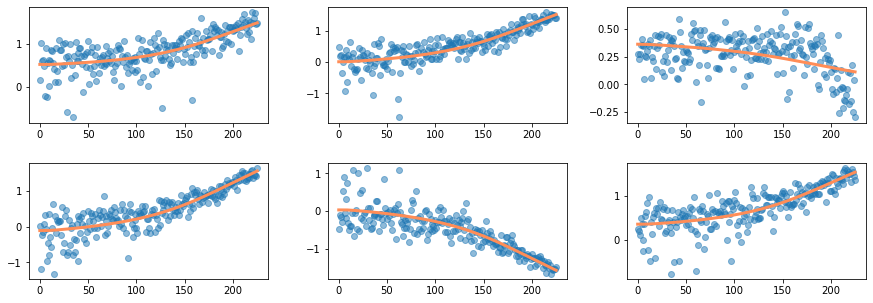

In [14]:
unit_index = 19
predict_sensors(net, X[unit_index], train_data[unit_index], unit_index)

In [15]:
# 计算传感器噪声方差
sigma2 = np.zeros(num_sensors)

for i in range(num_sensors):
    tmp_sigma2 = 0
    tmp_m = 0
    for j in range(num_train):
        gamma_j = gamma[j,i]
        sensor_data = train_data[j][:,i].detach().numpy()
        tmp_n = lengths[j]
        
        tmp_Psi = Psi[:tmp_n]
        sensor_path = tmp_Psi @ gamma_j
        
        tmp_sigma2 += np.power(sensor_path - sensor_data, 2).sum()
        tmp_m += (tmp_n - 6)
        
    sigma2[i] = tmp_sigma2/tmp_m
sigma2

array([0.08403961, 0.07826315, 0.02259331, 0.05922949, 0.06753976,
       0.07430189, 0.08454845])

In [16]:
# gamma的均值和协方差
cov_list = []
for i in range(num_sensors):
    data_i = gamma[:,i]
    cov_i = np.cov(data_i.T)
    cov_list.append(cov_i)
    
cov = block_diag(cov_list[0],cov_list[1],cov_list[2],cov_list[3],cov_list[4],cov_list[5],cov_list[6])
# cov = np.cov(gamma.reshape(num_train,-1).T)
mu = gamma.reshape(num_train,-1).mean(axis=0).reshape(-1,1)

cov.shape, mu.shape

((21, 21), (21, 1))

In [17]:
num_val = num_units-num_train

mu_i = np.zeros((num_val, 3*num_sensors,1)) 
cov_i = np.zeros((num_val,3*num_sensors,3*num_sensors))

for i in range(num_val):
    tmp_n = val_lengths[i]
    tmp_psi = Psi[:tmp_n]
    
    Psi_i = block_diag(tmp_psi,tmp_psi,tmp_psi,tmp_psi,tmp_psi,tmp_psi, tmp_psi)
    # 构建块对角矩阵
    omega_i = np.diag(np.repeat(sigma2.reshape(-1,1),tmp_n,axis=1).flatten())

    L_i = val_data[i].detach().numpy().T.flatten().reshape(-1,1) # n_i*1
    
    # 计算后验分布
    tmp_cov = inv(Psi_i.T @ inv(omega_i) @ Psi_i + inv(cov))
    tmp_mu = tmp_cov @ (Psi_i.T @ inv(omega_i) @ L_i + inv(cov) @ mu)
    
    mu_i[i] = tmp_mu
    cov_i[i] = tmp_cov

In [18]:
# for protottype
N, delta, K = 80, 1, 10 # 超参数
inputs = np.zeros((num_units,2*N,num_sensors))

for i in range(num_train):
    M = lengths[i]
    y_pred = Psi @ gamma[i].T
        
    M = lengths[i]
    t = torch.zeros(2*N, dtype=torch.long)
    for j in range(2*N):
        t[j] = M + (j-N+1) * delta
    
    inputs[i] = y_pred[t]

for i in range(num_val):
    M = val_lengths[i]
    y_pred = np.zeros((K,2*N,num_sensors))
    gamma_samples = np.random.multivariate_normal(mu_i[i].flatten(), cov_i[i], size=K)  
        
    t = torch.zeros(2*N, dtype=torch.long)
    for j in range(2*N):
        t[j] = M + (j-N+1) * delta
        
    for k in range(K):
        y_pred[k] = (Psi @ gamma_samples[k].reshape(num_sensors,-1).T)[t]
    
    inputs[i+num_train] = y_pred.mean(axis=0)

# 设置标签值
labels = np.hstack((np.zeros(N), np.ones(N))).reshape(1,-1)
labels = np.repeat(labels, num_units, axis=0)

inputs.shape, labels.shape

((100, 160, 7), (100, 160))

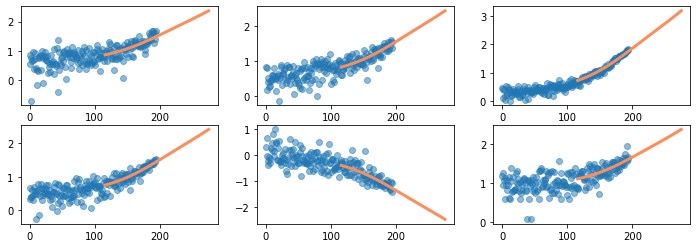

In [19]:
index = 0
sensor_data = train_data[index]
sensor_path = inputs[index]

M = lengths[index]
t = torch.zeros(2*N, dtype=torch.long)
for j in range(2*N):
    t[j] = M + (j-N+1) * delta

fig = plt.figure(figsize=(12,4))
for i in range(6):
    plt.subplot(2, 3, 1+i)
    plt.plot(sensor_data[:,i], 'o', alpha=0.5)
    plt.plot(t, sensor_path[:,i], color='#FF8D57', linewidth = 3.0)

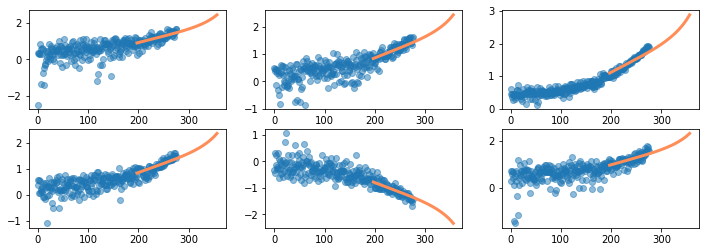

In [20]:
index = 1
sensor_data = val_data[index]
sensor_path = inputs[index+num_train]

M = val_lengths[index]
t = torch.zeros(2*N, dtype=torch.long)
for j in range(2*N):
    t[j] = M + (j-N+1) * delta

fig = plt.figure(figsize=(12,4))
for i in range(6):
    plt.subplot(2, 3, 1+i)
    plt.plot(sensor_data[:,i], 'o', alpha=0.5)
    plt.plot(t, sensor_path[:,i], color='#FF8D57', linewidth = 3.0)

In [21]:
np.save('inputs_svgd-3.npy',inputs)
np.save('labels_svgd-3.npy',labels)

In [22]:
df_test = pd.read_excel('test_data.xlsx')
num_test = df_test['Unit'].max()      # 测试数据数量

test_data = []
test_lengths = []
for i in range(num_test):
    Y = np.array(df_test[df_test['Unit']==i+1].iloc[:,2:]) 
    test_data.append(Y)
    test_lengths.append(len(Y))
    
mu_j = np.zeros((num_test, num_hiddens*num_sensors,1)) 
cov_j = np.zeros((num_test,num_hiddens*num_sensors,num_hiddens*num_sensors))

for i in range(num_test):
    tmp_n = test_lengths[i]
    tmp_psi = Psi[:tmp_n]
    
    Psi_i = block_diag(tmp_psi,tmp_psi,tmp_psi,tmp_psi,tmp_psi,tmp_psi,tmp_psi)
    # 构建块对角矩阵
    omega_i = np.diag(np.repeat(sigma2.reshape(-1,1),tmp_n,axis=1).flatten())

    L_i = test_data[i].T.flatten().reshape(-1,1) # n_i*1
    
    # 计算后验分布
    tmp_cov = inv(Psi_i.T @ inv(omega_i) @ Psi_i + inv(cov))
    tmp_mu = tmp_cov @ (Psi_i.T @ inv(omega_i) @ L_i + inv(cov) @ mu)
    
    mu_j[i] = tmp_mu
    cov_j[i] = tmp_cov

mu_j.shape, cov_j.shape

((100, 21, 1), (100, 21, 21))

In [23]:
np.save('test_mu_svgd-3.npy',mu_j)
np.save('test_cov_svgd-3.npy',cov_j)

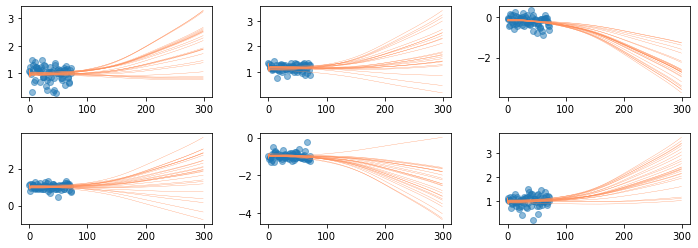

In [24]:
index, K, valid_len = 46, 25, 300
sensor_data = test_data[index]
tmp_Psi = Psi[:valid_len]
gamma_samples = np.random.multivariate_normal(mu_j[index].flatten(), cov_j[index], size=K)

fig = plt.figure(figsize=(12,4))

for i in range(6):
    plt.subplot(2, 3, 1+i)
    plt.plot(sensor_data[:,i], 'o', alpha = 0.5)
    for k in range(K):
        sensor_path = tmp_Psi @ gamma_samples[k].reshape(num_sensors,-1).T
        plt.plot(sensor_path[:,i], color='#FF8D57', linewidth=0.3)
        
plt.subplots_adjust(wspace = 0.25, hspace = 0.4)
plt.show()